# Import the necessary libraries

In [1]:
from sklearn.datasets import load_iris
import numpy as np
from sklearn.decomposition import PCA as SklearnPCA
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from itertools import combinations
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
from pca.pca import PCA as CustomPCA
from pca.utils import find_optimal_k

# Load the Iris dataset

In [2]:
iris = load_iris()
labels = iris.target
feature_names = iris.feature_names
label_names = iris.target_names

X = iris.data
y = iris.target

n_samples, n_features = X.shape

print(f"Number of samples: {n_samples}")
print(f"Number of features: {n_features}")

Number of samples: 150
Number of features: 4


# Visualize the dataset

In [3]:
feature_pairs = list(combinations(range(4), 2))
colors = ['#9467bd', '#2ca02c', '#ffbb78']
feature_pairs

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

In [4]:
def create_plot(features, angle):
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    
    _x = X[:, features[0]]
    _y = X[:, features[1]]

    points = np.vstack([_x, _y])
    rotated_points = rotation_matrix @ points

    fig = make_subplots(rows=2, cols=1, subplot_titles=(
        f'Rotated Scatter Plot ({angle} degrees)', 'PDF of Rotated X by Label'
    ), row_heights=[0.7, 0.3])
   # Add scatter plot for each label
    for label, color, label_name in zip(range(3), colors, label_names):
        fig.add_trace(go.Scatter(
            x=rotated_points[0][labels == label],
            y=rotated_points[1][labels == label],
            mode='markers',
            marker=dict(size=12, color=color),
            name=label_name,
            legendgroup=f'Label {label}',
            showlegend=True
        ), row=1, col=1)
    
   # Add combined PDF for each label
    for label, color, label_name in zip(range(3), colors, label_names):
        label_data = rotated_points[0][labels == label]
        kde = gaussian_kde(label_data)
        x_vals = np.linspace(label_data.min(), label_data.max(), 100)
        y_vals = kde(x_vals)
        fig.add_trace(go.Scatter(
            x=x_vals,
            y=y_vals,
            mode='lines',
            line=dict(color=color),
            name=label_name,
            legendgroup=f'Label {label}',
            showlegend=False
        ), row=2, col=1)

    fig.update_xaxes(title_text=feature_names[features[0]], row=1, col=1)
    fig.update_yaxes(title_text=feature_names[features[1]], row=1, col=1)
    fig.update_xaxes(title_text='Rotated X', row=2, col=1)
    fig.update_yaxes(title_text='Probability Density', row=2, col=1)
    
    return fig

In [5]:
features_index = 0
angle = 0

In [6]:
dropdown_buttons = [
    dict(
        label=f"{feature_names[features[0]]} vs {feature_names[features[1]]}",
        method="update",
        args=[
            {
                "x": [create_plot(features, angle).data[i].x for i in range(6)],
                "y": [create_plot(features, angle).data[i].y for i in range(6)]
            },
            {
                "xaxis.title": f"{feature_names[features[0]]} rotated by {angle} degrees",
                "yaxis.title": f"{feature_names[features[1]]} rotated by {angle} degrees",
                "title": f"{feature_names[features[0]]} vs {feature_names[features[1]]} rotated by {angle} degrees"
            }
        ]
    ) for features in feature_pairs
]


In [7]:
sliders = [
    dict(
        active=angle,
        currentvalue={
            "prefix": "Rotation: ",
            "suffix": " degrees",
        },
        pad={"t": 50},
        steps=[
            dict(
                method="update",
                label=f"{new_angle}",
                args=[
                    {
                        "x": [create_plot(feature_pairs[features_index], new_angle).data[i].x for i in range(6)],
                        "y": [create_plot(feature_pairs[features_index], new_angle).data[i].y for i in range(6)]
                    },
                    {
                        "title": f"{feature_names[feature_pairs[features_index][0]]} vs {feature_names[feature_pairs[features_index][1]]} rotated by {new_angle} degrees",
                        "xaxis.title": f"{feature_names[feature_pairs[features_index][0]]} rotated by {new_angle} degrees",
                        "yaxis.title": f"{feature_names[feature_pairs[features_index][1]]} rotated by {new_angle} degrees"
                    }
                ],
            )
            for new_angle in range(0, 361, 5)
        ],
    )
]


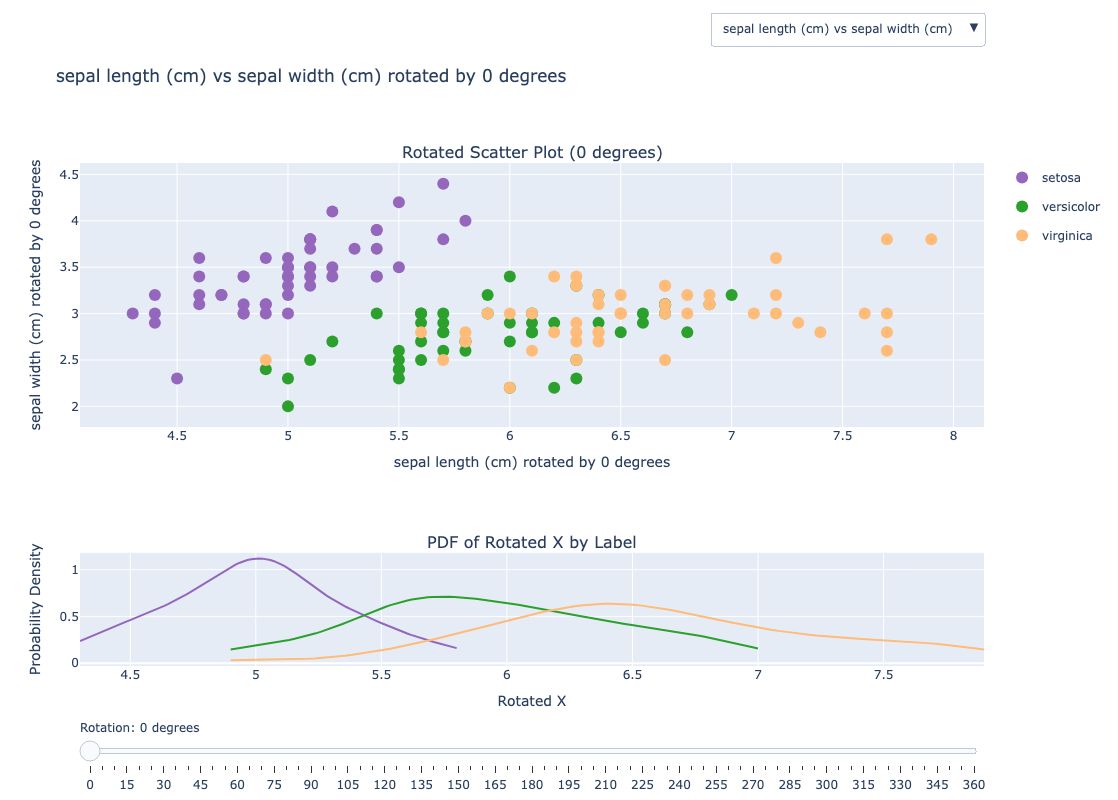

In [8]:
fig = create_plot(feature_pairs[features_index], angle)
fig.update_layout(
    updatemenus=[
        dict(
            type="dropdown",
            x=1.0,
            y=1.3,
            showactive=True,
            buttons=dropdown_buttons
        )
    ],
    sliders=sliders,
    width=800,
    height=800,
    title=f"{feature_names[feature_pairs[features_index][0]]} vs {feature_names[feature_pairs[features_index][1]]} rotated by {angle} degrees",
    xaxis_title=f"{feature_names[feature_pairs[features_index][0]]} rotated by {angle} degrees",
    yaxis_title=f"{feature_names[feature_pairs[features_index][1]]} rotated by {angle} degrees",
    showlegend=True
)
fig.show()

# PCA

## Preprocess the data

In [9]:
seed = 14192633
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [10]:
best_k = find_optimal_k(X_train, threshold=0.95)
print(f"Optimal k: {best_k}")

Optimal k: 2


## From Scratch

In [11]:
custom_pca = CustomPCA(n_components=2)
X_train = custom_pca.fit_transform(X_train)

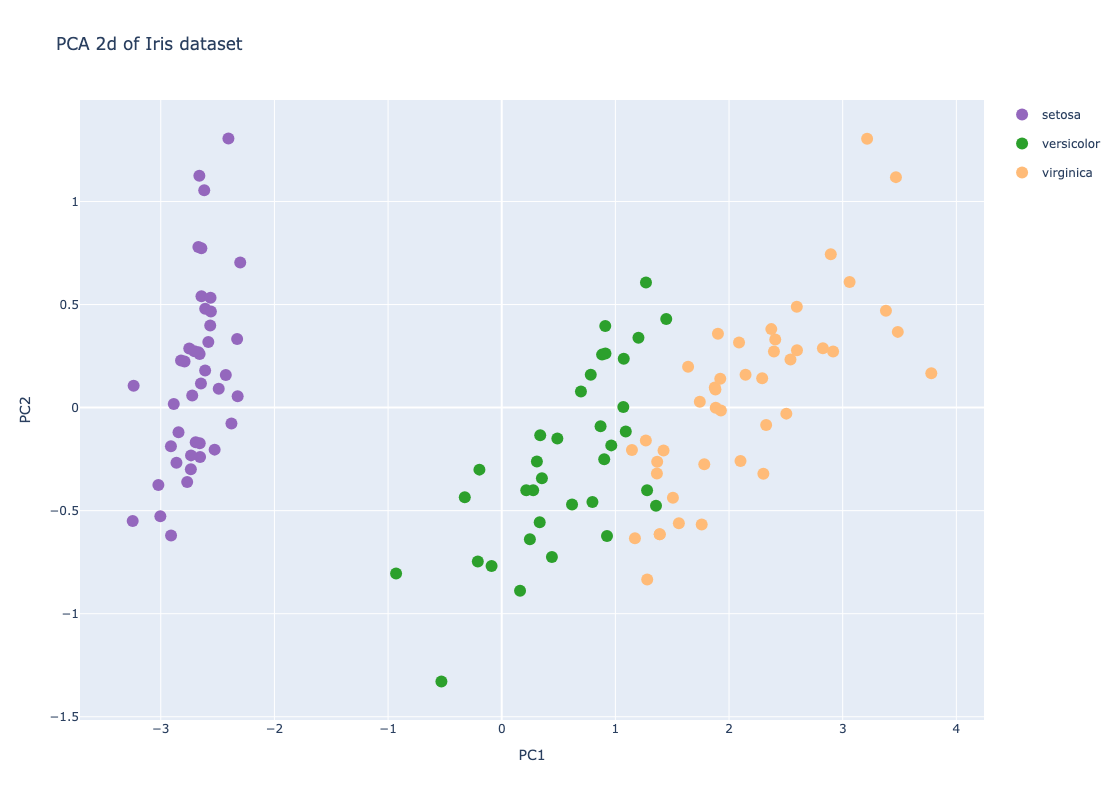

In [12]:
fig = go.Figure()

for label, color, label_name in zip(range(3), colors, label_names):
    fig.add_trace(go.Scatter(
        x=X_train[y_train == label, 0],
        y=X_train[y_train == label, 1],
        mode='markers',
        marker=dict(size=12, color=color),
        name=label_name,
        legendgroup=f'Label {label}',
        showlegend=True,
    ))

fig.update_layout(
    title='PCA 2d of Iris dataset', 
    xaxis_title='PC1', 
    yaxis_title='PC2',
    width=800,
    height=800
)
fig.show()

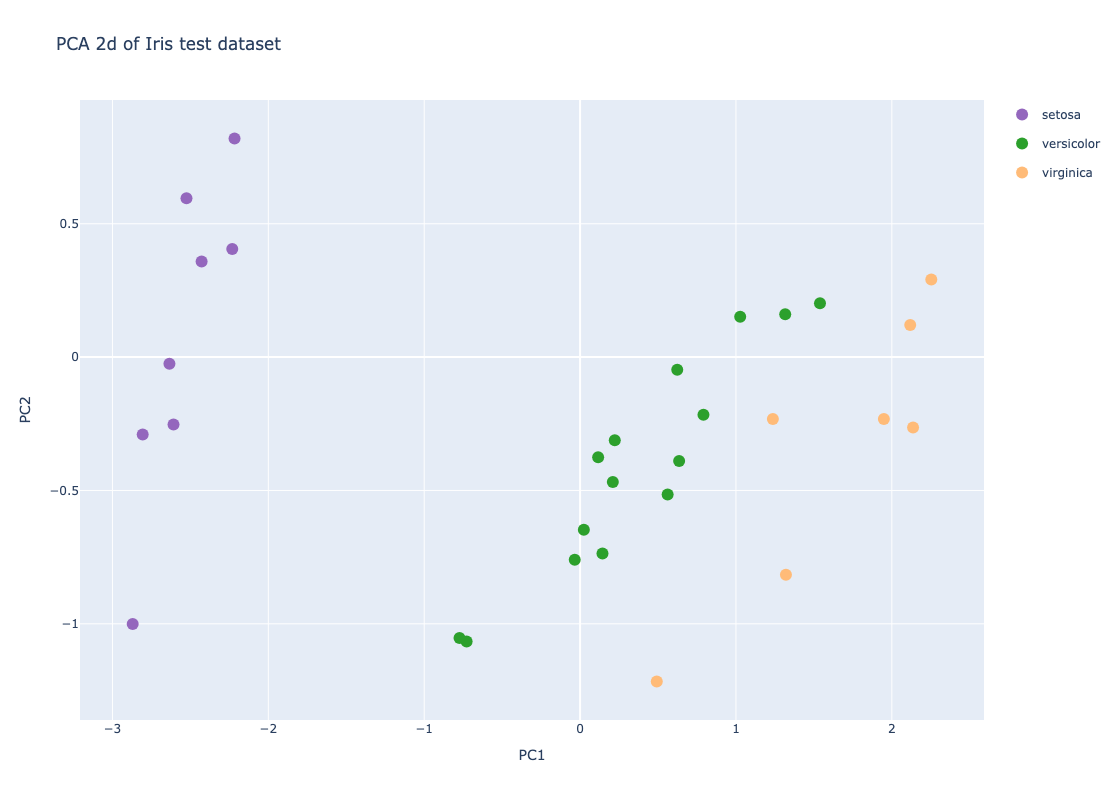

In [13]:
X_test = custom_pca.transform(X_test)

fig = go.Figure()

for label, color, label_name in zip(range(3), colors, label_names):\
    fig.add_trace(go.Scatter(
        x=X_test[y_test == label, 0],
        y=X_test[y_test == label, 1],
        mode='markers',
        marker=dict(size=12, color=color),
        name=label_name,
        legendgroup=f'Label {label}',
        showlegend=True,
    ))
    
fig.update_layout(
    title='PCA 2d of Iris test dataset', 
    xaxis_title='PC1', 
    yaxis_title='PC2',
    width=800,
    height=800
)
fig.show()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

best_k = find_optimal_k(X_train, threshold=0.99)
print(f"Optimal k: {best_k}")

Optimal k: 3


In [15]:
custom_pca = CustomPCA(n_components=3)
X_train = custom_pca.fit_transform(X_train)

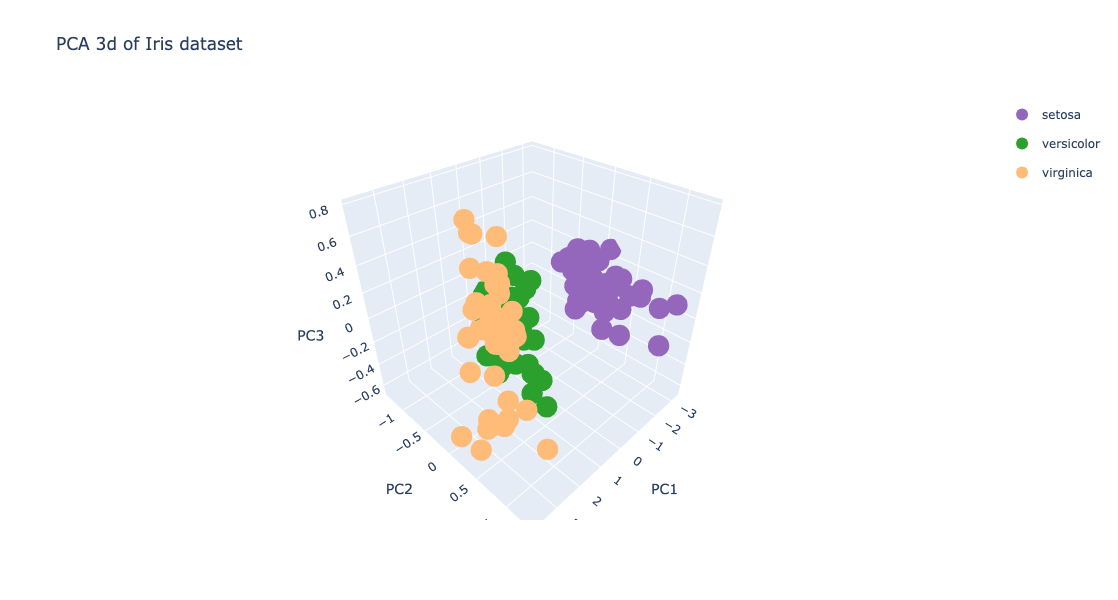

In [16]:
fig = go.Figure()

for label, color, label_name in zip(range(3), colors, label_names):\
    fig.add_trace(go.Scatter3d(
        x=X_train[y_train == label, 0],
        y=X_train[y_train == label, 1],
        z=X_train[y_train == label, 2],
        mode='markers',
        marker=dict(size=12, color=color),
        name=label_name,
        legendgroup=f'Label {label}',
        showlegend=True,
    ))
    
fig.update_layout(
    title='PCA 3d of Iris dataset', 
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    width=800,
    height=600
)
fig.show()

In [17]:
X_test = custom_pca.transform(X_test)

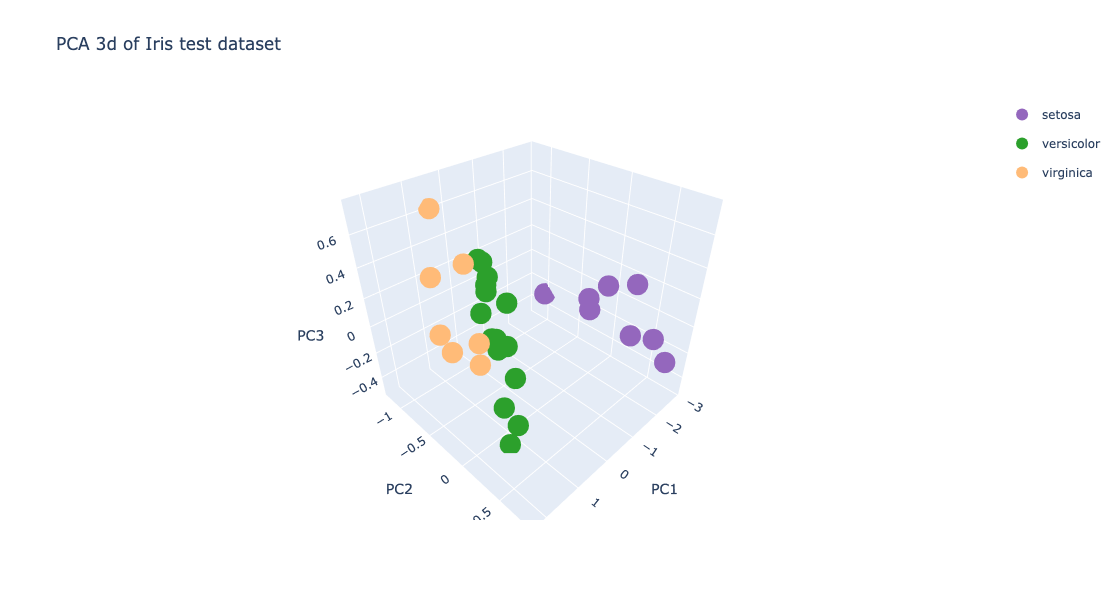

In [18]:
fig = go.Figure()

for label, color, label_name in zip(range(3), colors, label_names):
    fig.add_trace(go.Scatter3d(
        x=X_test[y_test == label, 0],
        y=X_test[y_test == label, 1],
        z=X_test[y_test == label, 2],
        mode='markers',
        marker=dict(size=12, color=color),
        name=label_name,
        legendgroup=f'Label {label}',
        showlegend=True,
    ))
    
fig.update_layout(
    title='PCA 3d of Iris test dataset', 
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    width=800,
    height=600
)
fig.show()

## From Sklearn

In [19]:
sklearn_pca = SklearnPCA(n_components=2)
X_pca = sklearn_pca.fit_transform(X)

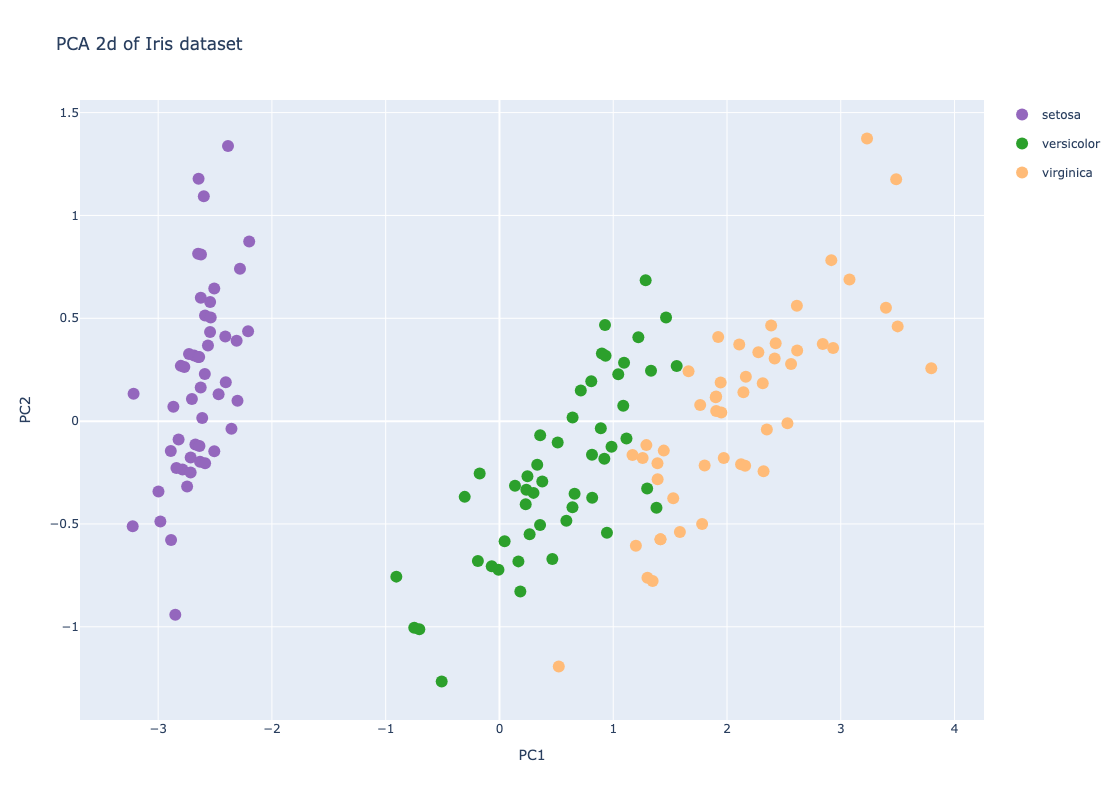

In [20]:
fig = go.Figure()

for label, color, label_name in zip(range(3), colors, label_names):
    fig.add_trace(go.Scatter(
        x=X_pca[y == label, 0],
        y=X_pca[y == label, 1],
        mode='markers',
        marker=dict(size=12, color=color),
        name=label_name,
        legendgroup=f'Label {label}',
        showlegend=True,
    ))
    
fig.update_layout(
    title='PCA 2d of Iris dataset', 
    xaxis_title='PC1', 
    yaxis_title='PC2',
    width=800,
    height=800
)